`pip install -U msgpack matplotlib pyvisa`

## 初始化

In [1]:
import numpy as np
from experiment import Experiment

console = Experiment(init_gpa=True)
console.add_flodict({
    f'ocra40_v{ch}': (np.array([0, 100]), np.array([0, 0])) for ch in range(40)
})
console.run()
console.__del__()

/home/feiyang/gr40/gr40c/server_comms.py:86: MarServerWarning: no RX data received
  warnings.warn(k, MarServerWarning)


## 采样

In [2]:
from typing import Literal
from time import sleep
import numpy as np, csv
from matplotlib import pyplot as plt
from experiment import Experiment
from pyvisa import ResourceManager

def read(typ: Literal['HIGH', 'MEAN', 'LOW']):
    # 读取脉冲幅度的测量值
    scope.write('MEASUrement:IMMed:SOUrce CH1')  # 设置测量源为通道 1
    scope.write('MEASUrement:IMMed:TYPe ' + typ)  # 设置测量类型为脉冲幅度
    return float(scope.query('MEASUrement:IMMed:VALUE?'))  # 读取脉冲幅度

def write(ch: int, amp: float):
    console = Experiment(init_gpa=False)
    console.add_flodict({
        f'ocra40_v{ch}': (np.array([10, 1000, 2000]), np.array([0, amp, 0])),
    })
    msg = console.run()
    console.__del__()
    return msg[1]

def sweep(ch: int):
    results = []
    def expt(amp: float):
        write(ch, amp)
        sleep(.2)
        high = read('HIGH')
        low = read('LOW')
        results.append([amp, high, low])
        if np.abs(high - low) > 1.2:  # 1.5V/30A
            return True
        return False
    
    scope.write('TRIGger:A:LEVel 0.08')
    for amp in np.linspace(0.02, 0.36, 18):
        if expt(amp):
            break
    scope.write('TRIGger:A:LEVel -0.08')
    for amp in np.linspace(-0.02, -0.36, 18):
        if expt(amp):
            break
    try:
        with open(f'./data/{ch}.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerows(results)
    except FileNotFoundError:
        print('未保存')
    return np.array(results)

try:
    scope.close()
except NameError:
    pass
# rm = ResourceManager()
# scope = rm.open_resource(rm.list_resources()[0])
# scope.query('*IDN?')

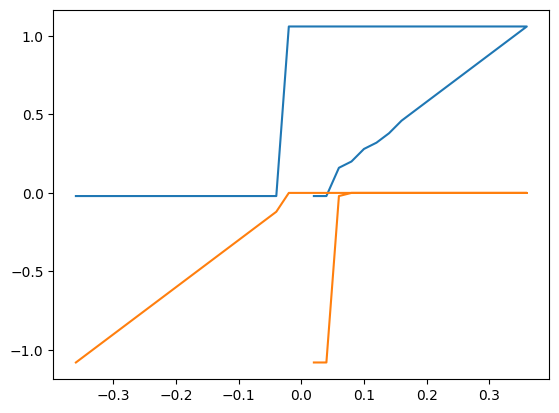

In [161]:
rst = np.array(sweep(0))
plt.plot(rst[:, 0], rst[:, 1])
plt.plot(rst[:, 0], rst[:, 2])

In [27]:
# scope.query('MEASUrement:IMMed:UNIT?')
scope.write('TRIGger:A:LEVel -0.3')

22

In [36]:
scope.query('TRIGger:STATe?')

'READY\n'

In [31]:
read('LOW')

-0.94

In [3]:
write(4, 0.1)

SyntaxError: invalid syntax (3181205662.py, line 1)

In [7]:
console = Experiment(init_gpa=False)
console.add_flodict({
    'ocra40_v4': (np.array([10, 1000, 2000]), np.array([0, -0.3, 0])),
})
msg = console.run()
console.__del__()
msg[1]
sleep(.1)
read('LOW')

-0.0376

## 拟合

In [29]:
import csv, numpy as np
from matplotlib import pyplot as plt

def import_ch(ch: int):
    with open(f'./data/{ch}.csv', 'r') as f:
        reader = csv.reader(f)
        return np.sort([
            [float(i) for i in row] for row in reader if len(row) == 3
        ], axis=0)

def 划分高低电平(data: np.ndarray):
    low = np.hstack((data[:17, 1], data[19:, 2]))
    high = np.hstack((data[:17, 2], data[19:, 1]))
    x = np.hstack((data[:17, 0], data[19:, 0]))
    return low, high, x

def import_all():
    coef = []
    series = []
    for ch in range(40):
        try:
            raw = import_ch(ch)
        except FileNotFoundError:
            continue
        low, high, x = 划分高低电平(raw)
        series.append([x, low, high])
        k, b = np.polyfit(x, high, 1)
        coef.append([ch, k, b])
    return np.array(coef), np.array(series)

def plot_raw(series: np.ndarray):
    plt.plot(series[:, 0], series[:, 1])
    plt.plot(series[:, 0], series[:, 2])

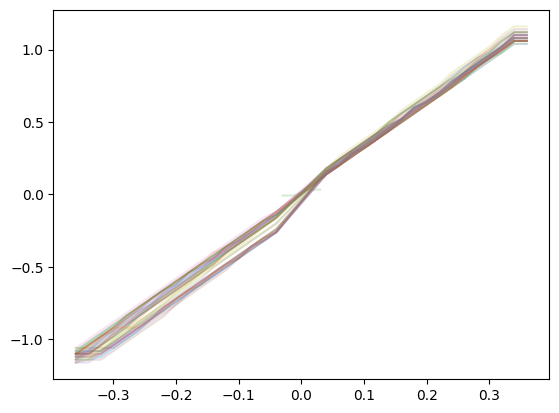

In [47]:
plt.close('all')
for ch in range(39):
    plt.plot(series[ch][0], series[ch][2], alpha=.2)

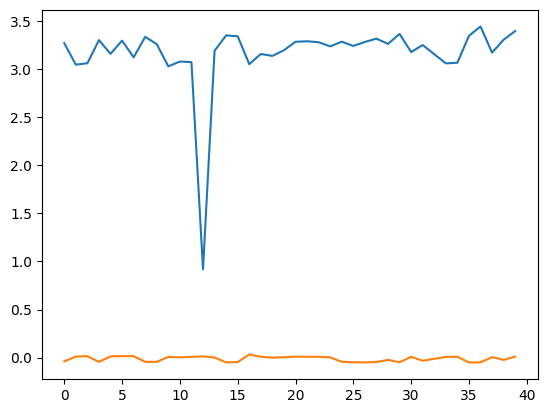

In [48]:
coef, series = import_all()
plt.plot(coef[:, 0], coef[:, 1])
plt.plot(coef[:, 0], coef[:, 2])

## 同步

In [39]:
import numpy as np

def 三角脉冲(峰值: float, 压摆率: float, 采样率: float):
    num_points = 2*round(np.abs(峰值) * 采样率 / 压摆率)
    print('波形点数：', num_points)
    x = 1e6 * np.arange(num_points) / 采样率
    lhs = np.linspace(0, 峰值, num_points//2)
    rhs = np.linspace(峰值, 0, num_points//2)
    y = np.hstack((lhs, rhs))
    return x, y

波形点数： 40


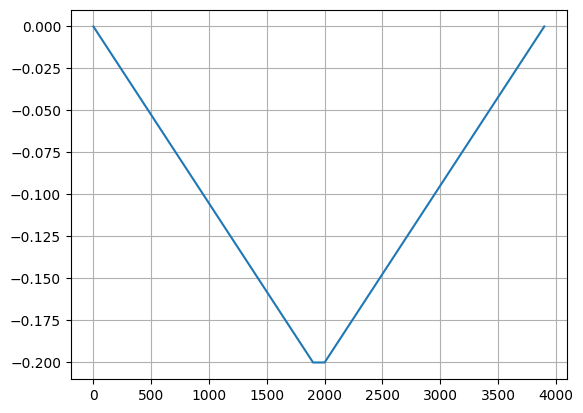

In [40]:
from matplotlib import pyplot as plt
x, y = 三角脉冲(-0.2, 100, 10000)
plt.plot(x, y)
plt.grid(True)

In [55]:
from experiment import Experiment

console = Experiment(init_gpa=False)
console.add_flodict({
    f'ocra40_v{ch}': 三角脉冲(0.1, 20, 10000) for ch in range(40)
    # 'ocra40_v12': 三角脉冲(0.1, 10, 10000)
    # 'ocra40_v39': (np.array([0, 1000, 5000]), np.array([0, 0.2, 0.6]))
})
console.run()
console.__del__()

波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100
波形点数： 100


## 测场图

In [2]:
def set_ch(ch: int, amp: float = 0.1):
    console = Experiment(init_gpa=False)
    console.add_flodict({
        f'ocra40_v{c}': (
            np.array([0, 1000]), 
            np.array([0, amp if c == ch else 0])
        ) for c in range(40)
    })
    msg = console.run()
    console.__del__()
    return msg[1]

In [ ]:
# 第一组
set_ch(0)

In [ ]:
# 第二组
set_ch(0)

In [ ]:
# 第三组
set_ch(0)

In [ ]:
# 第四组
set_ch(0)

In [ ]:
# 第五组
set_ch(0)

In [ ]:
# 第六组
set_ch(0)

In [ ]:
# 第七组
set_ch(0)